In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

In [9]:
# Defining data paths:
MODE = "train_data"

if MODE == "test_data":
    imagePath = './hecktor2022/hecktor2022_testing/imagesTs_resampled/'
    maskPath = './hecktor2022/hecktor2022_testing/labelsTs_resampled/'
    clinical_df = pd.read_csv("./hecktor2022/hecktor2022_testing/hecktor2022_clinical_info_testing.csv")
    endpoint = pd.read_csv("./hecktor2022/hecktor2022_testing/hecktor2022_endpoint_testing.csv")
    save_path = './Data/test_data/'
elif MODE == "train_data":
    imagePath = './hecktor2022/hecktor2022_training/imagesTr_resampled/'
    maskPath = './hecktor2022/hecktor2022_training/labelsTr_resampled/'
    clinical_df = pd.read_csv("./hecktor2022/hecktor2022_training/hecktor2022_patient_info_training.csv")
    endpoint = pd.read_csv("./hecktor2022/hecktor2022_training/hecktor2022_patient_endpoint_training.csv")
    save_path = './Data/train_data/'

In [10]:
clinical_df.head()

,PatientID,CenterID,Gender,Age,Tobacco,Alcohol,Performance_status,"HPV status (0=-, 1=+)",Surgery,Chemotherapy
0,CHUM-001,1,M,82,NaN,NaN,NaN,NaN,NaN,1
1,CHUM-002,1,M,73,NaN,NaN,NaN,NaN,NaN,1
2,CHUM-006,1,M,65,NaN,NaN,NaN,NaN,NaN,1
3,CHUM-007,1,F,70,NaN,NaN,NaN,NaN,NaN,0
4,CHUM-008,1,F,67,NaN,NaN,NaN,NaN,NaN,1


In [11]:
# Extracting patients IDs:
ids = clinical_df['PatientID'].to_list()

In [16]:
ids[:5]

['CHUM-001', 'CHUM-002', 'CHUM-006', 'CHUM-007', 'CHUM-008']

In [17]:
def load_images(IDs):
    print("Loading images ...")
    data = {}
    for id in tqdm(IDs):
        labelPath = os.path.join(maskPath, id + '.nii.gz')
        ctPath = os.path.join(imagePath, id + '__CT.nii.gz')
        petPath = os.path.join(imagePath, id + '__PT.nii.gz')
        mask = sitk.ReadImage(labelPath)
        CT = sitk.ReadImage(ctPath)
        PET = sitk.ReadImage(petPath)
        mask = sitk.GetArrayFromImage(mask)
        CT = sitk.GetArrayFromImage(CT)
        PET = sitk.GetArrayFromImage(PET)
        data[id] = (CT, PET, mask)
    return data

In [14]:
exemplary_data = load_images(ids[:5])

Loading images ...


100%|██████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.95s/it]


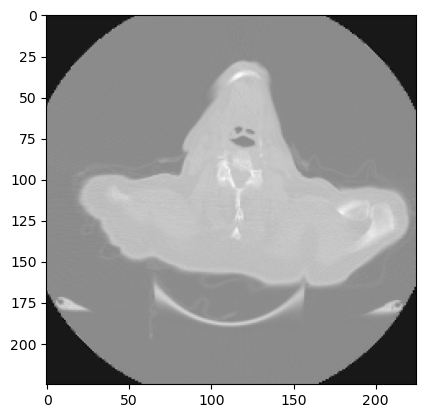

In [22]:
args = {
    "data": exemplary_data,
    "patient_ID": 'CHUM-001',
    "method": "CT",
    "slice": 39,
    "apply_mask": False
}

def visualize_raw_data(data, patient_ID, method, slice, apply_mask):
    assert method in ("CT", "PET")
    
    plt.set_cmap('gray')
    CT, PET, mask = data[patient_ID]
    img = CT if method == "CT" else PET
    img = img[slice]
    if apply_mask:
        img = img*mask[slice]
    plt.imshow(img)

visualize_raw_data(**args)

## Extracting Nodules

In [23]:
def load_image(id, maskPath, imagePath):
    maskPath = os.path.join(maskPath, id + '.nii.gz')
    ctPath = os.path.join(imagePath, id + '__CT.nii.gz')
    petPath = os.path.join(imagePath, id + '__PT.nii.gz')
    mask = sitk.ReadImage(maskPath)
    CT = sitk.ReadImage(ctPath)
    PET = sitk.ReadImage(petPath)
    mask = sitk.GetArrayFromImage(mask)
    CT = sitk.GetArrayFromImage(CT)
    PET = sitk.GetArrayFromImage(PET)
    return CT, PET, mask


def extract_nodule(patient_id, margin, maskPath, imagePath):
    CT, PET, mask = load_image(patient_id, maskPath, imagePath)
    segmentation = np.where(mask != 0)
    bbox = 0, 0, 0, 0
    if len(segmentation) != 0:
        z_min = int(np.min(segmentation[0]))
        z_max = int(np.max(segmentation[0]))
        x_min = int(np.min(segmentation[1]))
        x_max = int(np.max(segmentation[1]))
        y_min = int(np.min(segmentation[2]))
        y_max = int(np.max(segmentation[2]))   
        bbox = [(z_min, z_max), (x_min, x_max), (y_min, y_max)]
        #Center of bbox is computed by averaging extreme indexes on each of dimmensions.
        cbbox = [round((bbox[i][0]+bbox[i][1])/2) for i in range(3)]
        slices = (
                slice(cbbox[0]-margin, cbbox[0]+margin),
                slice(cbbox[1]-margin, cbbox[1]+margin),
                slice(cbbox[2]-margin, cbbox[2]+margin)
             )
        #Cropping a nodule volume from res_data by defined slices tupple.
        crop_CT = torch.Tensor(CT[slices])
        crop_PET = torch.Tensor(PET[slices])
        crop_mask = torch.Tensor(mask[slices])
    return crop_CT, crop_PET, crop_mask

In [24]:
Path(f"{save_path}/crops_CT").mkdir(parents=True, exist_ok=True)
Path(f"{save_path}/crops_PET").mkdir(parents=True, exist_ok=True)
Path(f"{save_path}/crops_mask").mkdir(parents=True, exist_ok=True)


args = {
    "IDs": ids,
    "margin": 15,
    "save_path": save_path,
    "maskPath": maskPath, 
    "imagePath": imagePath
}


def prepare_data(IDs, margin, save_path, maskPath, imagePath):
    print("Extracting nodules ...")
    for patient_id in tqdm(IDs):
        try:
            crop_CT, crop_PET, crop_mask = extract_nodule(patient_id, margin, maskPath, imagePath)
            torch.save(crop_CT.clone(), f"{save_path}/crops_CT/{patient_id}.pt")
            torch.save(crop_PET.clone(), f"{save_path}/crops_PET/{patient_id}.pt")
            torch.save(crop_mask.clone(), f"{save_path}/crops_mask/{patient_id}.pt")
        except Exception as e:
            print(f"Something wrong for patient: {patient_id}")
            print(e)
    return "Done"

In [25]:
prepare_data(**args)

Extracting nodules ...


100%|████████████████████████████████████████████████████| 524/524 [1:21:50<00:00,  9.37s/it]


'Done'

In [26]:
def visualize_crop(ID, slice, method, path):
    assert method in ("CT", "PET")
    img = torch.load(path+f"crops_{method}"+f"/{ID}.pt").numpy()
    plt.set_cmap('gray')
    plt.imshow(img[slice])

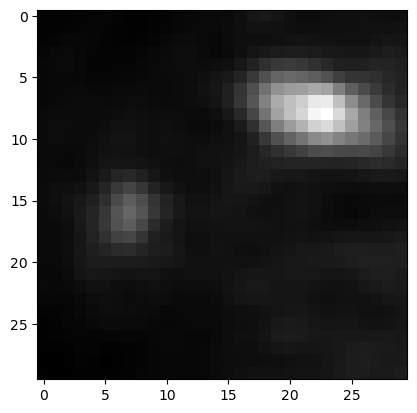

In [39]:
visualize_crop(ID='CHUM-001', slice=20, method="PET", path="./Data/train_data/")